# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_132  O14498                   19.885
Sample_011  P20827                   17.721
Sample_116  Q14624                   21.387
Sample_048  H7BY64;Q96NZ9;Q96NZ9-4   16.427
Sample_130  P29120;P29120-2          15.638
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups        
Sample_075  H0Y512;Q9HDC9;Q9HDC9-2   12.765
Sample_139  Q9BXP8                   13.810
Sample_209  O75781;O75781-2          15.611
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.263
            A0A075B6Q5                 12.335
            A0A075B6R2                 12.856
            A0A075B6S5                 12.877
            A0A087WSY4                 13.780
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.955
            Q9UI40;Q9UI40-2            11.411
            Q9UIW2                     12.745
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.710
            Q9UP79                     12.600
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.028,15.050,16.842,19.863,16.000,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.618,19.067,...,15.528,15.576,14.316,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.019,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.007,17.705,17.039,15.640,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.534,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.027,15.345,17.084,18.708,14.249,19.433,11.452,10.688
Sample_207,15.739,16.877,15.469,16.898,13.801,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.263,...,16.012,15.178,13.242,15.050,16.842,19.863,13.460,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.028,19.067,16.188,...,15.528,15.576,13.377,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.280,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.486,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.854,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.901,15.345,17.084,18.708,14.249,19.433,12.343,11.637
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 229.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.70it/s]

100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.80it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.81it/s]

100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.79it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.66it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.25it/s]

100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.81it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.25it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.95it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.63it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.61it/s]

100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.53it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.85it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.90it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.81it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.72it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.74it/s]

100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.26it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.81it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.32it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.99it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.86it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.20it/s]

100%|██████████| 9/9 [00:03<00:00,  2.03it/s]

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.53it/s]

 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

 40%|████      | 4/10 [00:01<00:02,  2.32it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.23it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.28it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.29it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.28it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.31it/s]

100%|██████████| 10/10 [00:04<00:00,  2.36it/s]

100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.54it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.62it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.10it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.75it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.73it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.74it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.81it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.75it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.79it/s]

100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

100%|██████████| 11/11 [00:03<00:00,  2.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.47it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.22it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.77it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.88it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.96it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

100%|██████████| 12/12 [00:04<00:00,  2.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.42it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.90it/s]

 31%|███       | 4/13 [00:01<00:02,  3.36it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.14it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.02it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.52it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.11it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.95it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.91it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.97it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.06it/s]

100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.28it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.07it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.45it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.06it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.18it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.21it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.14it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.15it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.13it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.26it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.30it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.51it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.33it/s]

 20%|██        | 3/15 [00:01<00:05,  2.35it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.19it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.28it/s]

 40%|████      | 6/15 [00:02<00:03,  2.38it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.48it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.59it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.63it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.79it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.82it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.76it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.41it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.20it/s]

100%|██████████| 15/15 [00:06<00:00,  2.19it/s]

100%|██████████| 15/15 [00:06<00:00,  2.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.068 0.025          0.805 0.314       0.135   
2             0.005 0.004      0.064 0.025          0.668 0.120       0.595   
3             0.006 0.005      0.077 0.030          0.762 0.081       0.745   
4             0.004 0.003      0.058 0.019          0.772 0.083       0.734   
5             0.004 0.003      0.061 0.021          0.773 0.089       0.724   
6             0.005 0.004      0.064 0.025          0.778 0.102       0.743   
7             0.004 0.000      0.048 0.009          0.808 0.085       0.844   
8             0.005 0.004      0.068 0.025          0.810 0.088       0.843   
9             0.005 0.004      0.056 0.021          0.802 0.091       0.834   
10            0.004 0.002      0.048 0.011          0.809 0.089       0.825   
11            0.006 0.004      0.066 0.023          0.816 0.082       0.837   
12            0.006 0.005      0.069 0.027          0.812 0.078       0.831   
13            0.005 0.003      0.052 0.014          0.829 0.075       0.835   
14            0.004 0.002      0.048 0.007          0.818 0.080       0.836   
15            0.005 0.002      0.052 0.014          0.816 0.079       0.838   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.223 0.132                  0.560 0.043        0.862   
2          0.123   0.621 0.100                  0.685 0.077        0.781   
3          0.095   0.750 0.071                  0.786 0.058        0.853   
4          0.099   0.748 0.070                  0.786 0.057        0.855   
5          0.102   0.742 0.073                  0.782 0.058        0.858   
6          0.098   0.755 0.075                  0.790 0.062        0.857   
7          0.094   0.821 0.064                  0.847 0.055        0.901   
8          0.089   0.821 0.063                  0.846 0.054        0.899   
9          0.102   0.813 0.072                  0.840 0.062        0.898   
10         0.106   0.812 0.073                  0.839 0.062        0.901   
11         0.094   0.823 0.070                  0.848 0.060        0.915   
12         0.086   0.818 0.064                  0.844 0.055        0.913   
13         0.086   0.830 0.068                  0.855 0.059        0.916   
14         0.094   0.823 0.068                  0.849 0.060        0.916   
15         0.094   0.824 0.070                  0.849 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.088        210.000 0.000  
2          0.078                  0.696 0.101        210.000 0.000  
3          0.060                  0.805 0.086        210.000 0.000  
4          0.061                  0.811 0.091        210.000 0.000  
5          0.060                  0.813 0.089        210.000 0.000  
6          0.056                  0.817 0.083        210.000 0.000  
7          0.049                  0.876 0.061        210.000 0.000  
8          0.049                  0.875 0.062        210.000 0.000  
9          0.050                  0.874 0.063        210.000 0.000  
10         0.050                  0.878 0.064        210.000 0.000  
11         0.049                  0.902 0.058        210.000 0.000  
12         0.050                  0.898 0.059        210.000 0.000  
13         0.048                  0.899 0.056        210.000 0.000  
14         0.049                  0.903 0.054        210.000 0.000  
15         0.050                  0.901 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 477.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.61it/s]

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.47it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.06it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.70it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.51it/s]

100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.88it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.17it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.05it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.13it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.17it/s]

100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.27it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.42it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.16it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.81it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.78it/s]

100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.78it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.82it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.24it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.92it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.75it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.57it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.50it/s]

100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.46it/s]

 30%|███       | 3/10 [00:00<00:01,  3.63it/s]

 40%|████      | 4/10 [00:01<00:01,  3.13it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.79it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.63it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.57it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.40it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.46it/s]

100%|██████████| 10/10 [00:03<00:00,  2.31it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.82it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.51it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.95it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.79it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.64it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.49it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.40it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.28it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.31it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.53it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.06it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.82it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.67it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.60it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.56it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.24it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.25it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.21it/s]

100%|██████████| 12/12 [00:04<00:00,  2.31it/s]

100%|██████████| 12/12 [00:04<00:00,  2.55it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.68it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.11it/s]

 31%|███       | 4/13 [00:01<00:03,  2.80it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.67it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.50it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.12it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.16it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.14it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.27it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

100%|██████████| 13/13 [00:05<00:00,  2.43it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.40it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.19it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.85it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.72it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.70it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.58it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.29it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.28it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.30it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.30it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.31it/s]

100%|██████████| 14/14 [00:05<00:00,  2.31it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.21it/s]

 20%|██        | 3/15 [00:00<00:03,  3.80it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.43it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.10it/s]

 40%|████      | 6/15 [00:01<00:03,  2.89it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.51it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.57it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.60it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.35it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.43it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.56it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.64it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.76it/s]

100%|██████████| 15/15 [00:05<00:00,  2.81it/s]

100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.065 0.029          0.107 0.279       0.011   
2             0.007 0.008      0.080 0.026          0.667 0.128       0.536   
3             0.005 0.004      0.069 0.028          0.700 0.108       0.555   
4             0.006 0.006      0.076 0.028          0.720 0.099       0.569   
5             0.006 0.005      0.077 0.034          0.806 0.091       0.795   
6             0.005 0.004      0.057 0.017          0.804 0.088       0.789   
7             0.006 0.004      0.065 0.028          0.797 0.087       0.798   
8             0.005 0.003      0.057 0.022          0.788 0.086       0.796   
9             0.005 0.005      0.055 0.017          0.781 0.084       0.797   
10            0.004 0.002      0.050 0.011          0.800 0.083       0.806   
11            0.003 0.000      0.040 0.004          0.796 0.086       0.809   
12            0.004 0.002      0.049 0.009          0.788 0.083       0.806   
13            0.004 0.002      0.053 0.013          0.794 0.082       0.804   
14            0.005 0.003      0.052 0.012          0.784 0.077       0.798   
15            0.005 0.004      0.061 0.023          0.795 0.077       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.868   
2          0.114   0.587 0.099                  0.666 0.073        0.709   
3          0.121   0.611 0.097                  0.688 0.066        0.745   
4          0.119   0.628 0.090                  0.702 0.060        0.754   
5          0.106   0.796 0.077                  0.826 0.064        0.898   
6          0.111   0.791 0.078                  0.822 0.064        0.895   
7          0.103   0.792 0.065                  0.822 0.054        0.896   
8          0.107   0.786 0.072                  0.818 0.059        0.895   
9          0.102   0.784 0.067                  0.815 0.056        0.893   
10         0.113   0.798 0.076                  0.828 0.063        0.903   
11         0.113   0.797 0.075                  0.827 0.062        0.904   
12         0.115   0.792 0.078                  0.823 0.065        0.902   
13         0.114   0.794 0.074                  0.825 0.061        0.902   
14         0.117   0.786 0.075                  0.818 0.063        0.900   
15         0.105   0.792 0.069                  0.823 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.832 0.086        210.000 0.000  
2          0.085                  0.683 0.100        210.000 0.000  
3          0.074                  0.677 0.098        210.000 0.000  
4          0.067                  0.706 0.089        210.000 0.000  
5          0.051                  0.866 0.068        210.000 0.000  
6          0.052                  0.863 0.070        210.000 0.000  
7          0.052                  0.866 0.064        210.000 0.000  
8          0.053                  0.865 0.065        210.000 0.000  
9          0.052                  0.864 0.065        210.000 0.000  
10         0.051                  0.878 0.062        210.000 0.000  
11         0.050                  0.879 0.060        210.000 0.000  
12         0.049                  0.876 0.060        210.000 0.000  
13         0.050                  0.876 0.062        210.000 0.000  
14         0.050                  0.874 0.061        210.000 0.000  
15         0.048                  0.878 0.060 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 982.96it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.41it/s]

100%|██████████| 3/3 [00:00<00:00, 22.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.59it/s]

100%|██████████| 4/4 [00:00<00:00, 16.64it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.67it/s]

100%|██████████| 5/5 [00:00<00:00, 15.20it/s]

100%|██████████| 5/5 [00:00<00:00, 15.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 26.38it/s]

100%|██████████| 6/6 [00:00<00:00, 18.32it/s]

100%|██████████| 6/6 [00:00<00:00, 19.15it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.96it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.18it/s]

100%|██████████| 7/7 [00:00<00:00, 12.32it/s]

100%|██████████| 7/7 [00:00<00:00, 12.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.98it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.20it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.79it/s]

100%|██████████| 8/8 [00:00<00:00, 13.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 24.82it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.82it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 18.41it/s]

100%|██████████| 9/9 [00:00<00:00, 19.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.21it/s]

 60%|██████    | 6/10 [00:00<00:00, 13.85it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.98it/s]

100%|██████████| 10/10 [00:00<00:00, 13.81it/s]

100%|██████████| 10/10 [00:00<00:00, 14.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.43it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.86it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.57it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.77it/s]

100%|██████████| 11/11 [00:00<00:00, 14.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.56it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.33it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.28it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.07it/s]

100%|██████████| 12/12 [00:00<00:00, 13.54it/s]

100%|██████████| 12/12 [00:00<00:00, 14.82it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 27.66it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 22.96it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 20.34it/s]

100%|██████████| 13/13 [00:00<00:00, 16.20it/s]

100%|██████████| 13/13 [00:00<00:00, 18.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 26.24it/s]

 43%|████▎     | 6/14 [00:00<00:00, 20.24it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 19.13it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 19.66it/s]

100%|██████████| 14/14 [00:00<00:00, 20.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.68it/s]

 40%|████      | 6/15 [00:00<00:00, 20.31it/s]

 60%|██████    | 9/15 [00:00<00:00, 19.32it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 16.81it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 17.11it/s]

100%|██████████| 15/15 [00:00<00:00, 17.64it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.061 0.025          0.000 0.000       0.000   
2             0.006 0.005      0.067 0.024          0.500 0.157       0.215   
3             0.004 0.001      0.062 0.025          0.622 0.096       0.526   
4             0.004 0.001      0.046 0.006          0.635 0.085       0.560   
5             0.004 0.001      0.050 0.012          0.653 0.087       0.558   
6             0.003 0.002      0.042 0.013          0.655 0.090       0.585   
7             0.004 0.002      0.042 0.013          0.648 0.090       0.569   
8             0.003 0.000      0.043 0.010          0.648 0.086       0.588   
9             0.003 0.000      0.030 0.005          0.649 0.087       0.590   
10            0.003 0.001      0.030 0.005          0.649 0.079       0.605   
11            0.003 0.001      0.041 0.008          0.654 0.094       0.590   
12            0.003 0.001      0.031 0.006          0.695 0.079       0.667   
13            0.003 0.001      0.031 0.006          0.692 0.081       0.661   
14            0.004 0.002      0.046 0.017          0.693 0.089       0.650   
15            0.004 0.002      0.044 0.016          0.684 0.089       0.645   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.751   
2          0.075   0.292 0.087                  0.523 0.048        0.613   
3          0.112   0.563 0.087                  0.644 0.064        0.740   
4          0.109   0.589 0.080                  0.661 0.059        0.745   
5          0.116   0.595 0.087                  0.670 0.063        0.768   
6          0.114   0.612 0.089                  0.679 0.068        0.773   
7          0.117   0.600 0.089                  0.671 0.067        0.765   
8          0.119   0.610 0.090                  0.677 0.067        0.780   
9          0.121   0.612 0.093                  0.678 0.070        0.774   
10         0.117   0.622 0.090                  0.684 0.066        0.778   
11         0.122   0.615 0.098                  0.681 0.073        0.788   
12         0.112   0.675 0.078                  0.726 0.063        0.814   
13         0.114   0.671 0.081                  0.722 0.065        0.810   
14         0.120   0.666 0.092                  0.720 0.071        0.809   
15         0.113   0.659 0.087                  0.713 0.068        0.805   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.694 0.082        210.000 0.000  
2          0.067                  0.551 0.056        210.000 0.000  
3          0.064                  0.696 0.068        210.000 0.000  
4          0.061                  0.700 0.072        210.000 0.000  
5          0.065                  0.724 0.063        210.000 0.000  
6          0.064                  0.737 0.063        210.000 0.000  
7          0.063                  0.726 0.063        210.000 0.000  
8          0.059                  0.740 0.068        210.000 0.000  
9          0.061                  0.732 0.070        210.000 0.000  
10         0.061                  0.732 0.067        210.000 0.000  
11         0.060                  0.746 0.070        210.000 0.000  
12         0.058                  0.763 0.071        210.000 0.000  
13         0.058                  0.760 0.074        210.000 0.000  
14         0.057                  0.756 0.072        210.000 0.000  
15         0.056                  0.751 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,2,2
score_time,3,2,2
test_precision,13,5,12
test_recall,7,11,12
test_f1,13,10,12
test_balanced_accuracy,13,10,12
test_roc_auc,14,11,12
test_average_precision,14,11,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.41it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.42it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.65it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.27it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.05it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.75it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.73it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.95it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.18it/s]

100%|██████████| 11/11 [00:02<00:00,  4.41it/s]

100%|██████████| 11/11 [00:02<00:00,  4.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 27.22it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 24.29it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 23.26it/s]

100%|██████████| 12/12 [00:00<00:00, 23.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 10.43it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.56it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.27it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.04it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.93it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.93it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.66it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.53it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.44it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  5.38it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.47it/s]

100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

100%|██████████| 14/14 [00:02<00:00,  5.75it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


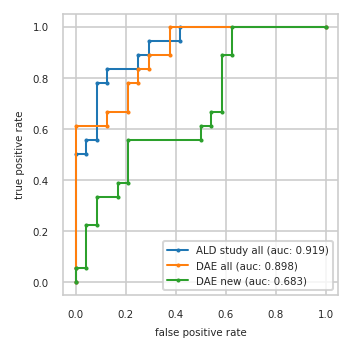

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.500   0.000 0.611   0.042 0.056
3          0.042 0.500   0.125 0.611   0.042 0.222
4          0.042 0.556   0.125 0.667   0.083 0.222
5          0.083 0.556   0.208 0.667   0.083 0.333
6          0.083 0.778   0.208 0.778   0.167 0.333
7          0.125 0.778   0.250 0.778   0.167 0.389
8          0.125 0.833   0.250 0.833   0.208 0.389
9          0.250 0.833   0.292 0.833   0.208 0.556
10         0.250 0.889   0.292 0.889   0.500 0.556
11         0.292 0.889   0.375 0.889   0.500 0.611
12         0.292 0.944   0.375 1.000   0.542 0.611
13         0.417 0.944   1.000 1.000   0.542 0.667
14         0.417 1.000     NaN   NaN   0.583 0.667
15         1.000 1.000     NaN   NaN   0.583 0.889
16           NaN   NaN     NaN   NaN   0.625 0.889
17           NaN   NaN     NaN   NaN   0.625 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,I3L3R5,B7Z5R6;Q14596;Q14596-2,B7Z5R6;Q14596;Q14596-2
2,Q15782;Q15782-6,Q12841;Q12841-2,A0A0C4DGV8;Q13214;Q13214-2
3,P04075,Q9Y2T3;Q9Y2T3-3,P31321
4,P61981,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P14174,E9PK25;G3V1A4;P23528
6,Q9Y2T3;Q9Y2T3-3,P61981,Q9NZU1
7,Q6EMK4,A0A0C4DGY8;D6RA00;Q9UHY7,Q96GD0
8,P00338;P00338-3,Q14894,P51674;P51674-2;P51674-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


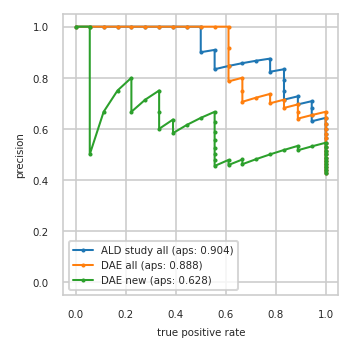

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.517 0.833
14         0.643 1.000     0.643 1.000     0.500 0.778
15         0.630 0.944     0.667 1.000     0.481 0.722
16         0.654 0.944     0.654 0.944     0.462 0.667
17         0.680 0.944     0.640 0.889     0.480 0.667
18         0.708 0.944     0.667 0.889     0.458 0.611
19         0.696 0.889     0.696 0.889     0.478 0.611
20         0.727 0.889     0.682 0.833     0.455 0.556
21         0.714 0.833     0.714 0.833     0.476 0.556
22         0.750 0.833     0.700 0.778     0.500 0.556
23         0.789 0.833     0.737 0.778     0.526 0.556
24         0.833 0.833     0.722 0.722     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.846 0.611     0.846 0.611     0.615 0.444
30         0.833 0.556     0.917 0.611     0.583 0.389
31         0.909 0.556     1.000 0.611     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


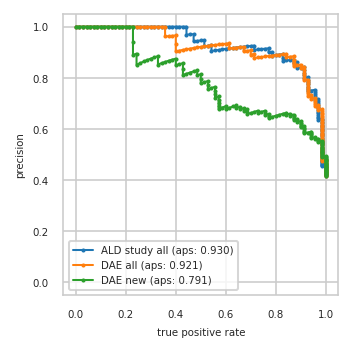

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


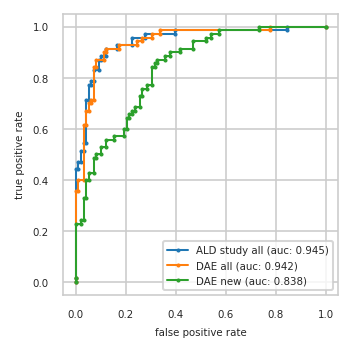

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}